In [23]:
# importing required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

# define matplotlib style
plt.style.use("ggplot")

def round_to_ndigits(i,n):
    return float('{:g}'.format(float('{:.{p}g}'.format(i, p=n))))

round_num = np.vectorize(lambda x: round_to_ndigits(x, 3))#, otypes=np.float)



In [24]:
# headers for each column
roundtripTime_header = "Roundtrip Time (s)"
payloadSize_header = "Payload Size (bytes)"

arrivalTime_header = "Arrival Time (s)"
expectedBandwidth_header = "Expected bandwidth (Hz)"

physicalLayer_header = "Physical Layer"
distance_header = "Distance (cm)"
mtu_header = "ATT Maximum Transmission Unit (bytes)"
adapter_header = "Adapter"

#phyTypes = ["LE1M", "LE2M"]
#distances = [0, 300, 600, 900, 1200, 1500]
#tests = ["roundtrip", "bandwidth"]
#mtuTypes = [23, 251]
#adapters = ["hci0", "hci1"]

phyTypes = ["LE1M"]
distances = [0, 300, 600, 900]
tests = ["roundtrip",]
mtuTypes = [251]
adapters = ["hci0",]

roundtrip_tests = pd.DataFrame(columns=[roundtripTime_header, payloadSize_header, adapter_header, physicalLayer_header, distance_header, mtu_header], dtype=None)
roundtrip_tests[roundtripTime_header] = roundtrip_tests[roundtripTime_header].astype(np.float)
roundtrip_tests[payloadSize_header] = roundtrip_tests[payloadSize_header].astype(np.int)
roundtrip_tests[adapter_header] = roundtrip_tests[adapter_header].astype("string")
roundtrip_tests[physicalLayer_header] = roundtrip_tests[physicalLayer_header].astype("string")
roundtrip_tests[distance_header] = roundtrip_tests[distance_header].astype(np.int)
roundtrip_tests[mtu_header] = roundtrip_tests[mtu_header].astype(np.int)

bandwidth_tests = pd.DataFrame(columns=[arrivalTime_header, payloadSize_header, expectedBandwidth_header, adapter_header, physicalLayer_header, distance_header, mtu_header])
bandwidth_tests[arrivalTime_header] = bandwidth_tests[arrivalTime_header].astype(np.float)
bandwidth_tests[expectedBandwidth_header] = bandwidth_tests[expectedBandwidth_header].astype(np.float)
bandwidth_tests[payloadSize_header] = bandwidth_tests[payloadSize_header].astype(np.int)
bandwidth_tests[adapter_header] = bandwidth_tests[adapter_header].astype("string")
bandwidth_tests[physicalLayer_header] = bandwidth_tests[physicalLayer_header].astype("string")
bandwidth_tests[distance_header] = bandwidth_tests[distance_header].astype(np.int)
bandwidth_tests[mtu_header] = bandwidth_tests[mtu_header].astype(np.int)



for test in tests:
    for adapter in adapters:
        for distance in distances:
            for phy in phyTypes:
                for mtu in mtuTypes:
                    fileName = "{}-{}_results_at_{}cm{}_MTU{}.csv".format(adapter, test, distance, phy, mtu)
                    
                    # importing data 
                    raw_data = pd.read_csv(fileName)
                    raw_data[adapter_header] = adapter
                    raw_data[physicalLayer_header] = phy
                    raw_data[distance_header] = distance
                    raw_data[mtu_header] = mtu
                    
                    raw_data = raw_data.convert_dtypes()
                    if test == "roundtrip":
                        data = raw_data.iloc[0:0,:].copy()
                        payloadSizes = raw_data[payloadSize_header].unique()

                        # get average roundtrip time for each payload
                        for payload in payloadSizes:
                            payloadData = raw_data[(raw_data[payloadSize_header] == payload)]
                            data = data.append(payloadData[(payloadData[roundtripTime_header] > payloadData[roundtripTime_header].quantile(0.20)) & (payloadData[roundtripTime_header] < payloadData[roundtripTime_header].quantile(0.80))].mean(numeric_only=True), ignore_index=True)
                            print(payloadData[(payloadData[roundtripTime_header] > payloadData[roundtripTime_header].quantile(0.20)) & 
                            (payloadData[roundtripTime_header] < payloadData[roundtripTime_header].quantile(0.80))])
                            
                        data[physicalLayer_header] = phy
                        data[adapter_header] = adapter
                        roundtrip_tests = roundtrip_tests.append(data.astype(roundtrip_tests.dtypes), ignore_index=True)
                    else:
                        # TODO: process bandwidth data tests
                        bandwidth_tests = bandwidth_tests.append(raw_data, ignore_index=True)




roundtrip_tests.sort_values(by=[adapter_header, physicalLayer_header, distance_header, mtu_header, payloadSize_header], ascending=True, inplace=True)
bandwidth_tests.sort_values(by=[adapter_header, physicalLayer_header, distance_header, mtu_header, expectedBandwidth_header], ascending=True, inplace=True)


#print(roundtrip_tests)
#print(bandwidth_tests)


   Roundtrip Time (s)  Payload Size (bytes) Adapter Physical Layer  \
1            0.047192                     1    hci0           LE1M   
3            0.040537                     1    hci0           LE1M   
4            0.039868                     1    hci0           LE1M   

   Distance (cm)  ATT Maximum Transmission Unit (bytes)  
1              0                                    251  
3              0                                    251  
4              0                                    251  
   Roundtrip Time (s)  Payload Size (bytes) Adapter Physical Layer  \
5            0.040451                     3    hci0           LE1M   
6            0.039731                     3    hci0           LE1M   
8            0.040289                     3    hci0           LE1M   

   Distance (cm)  ATT Maximum Transmission Unit (bytes)  
5              0                                    251  
6              0                                    251  
8              0                

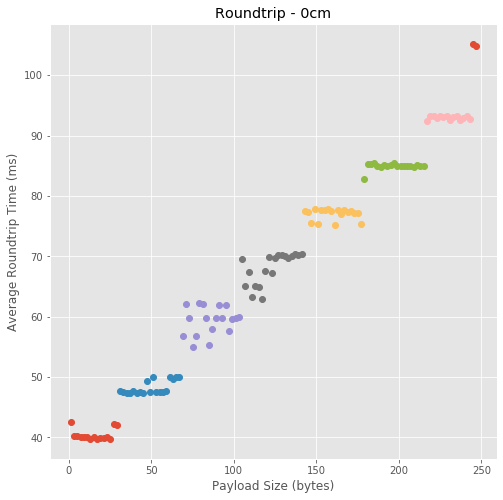

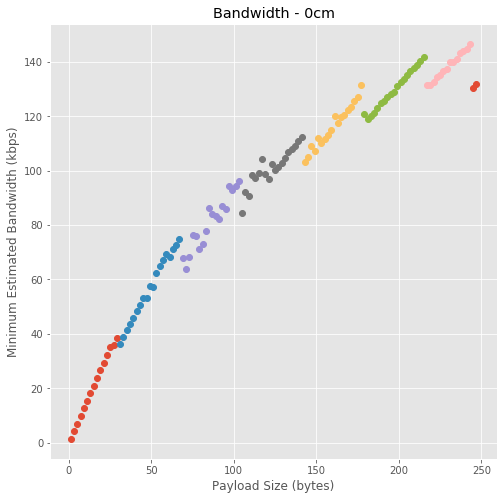

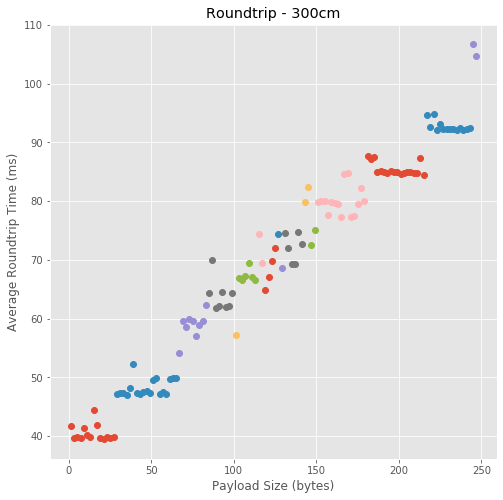

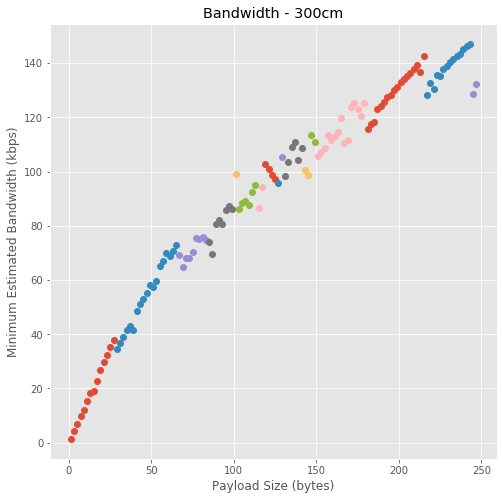

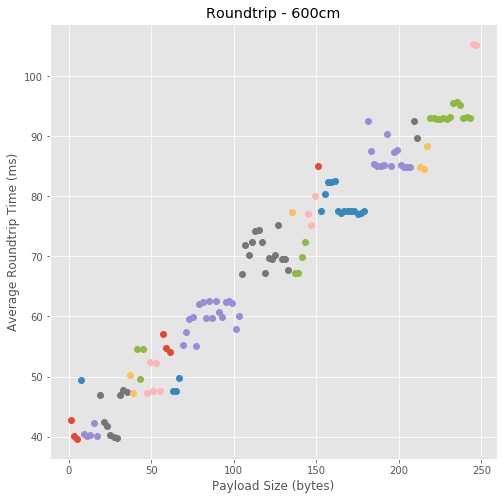

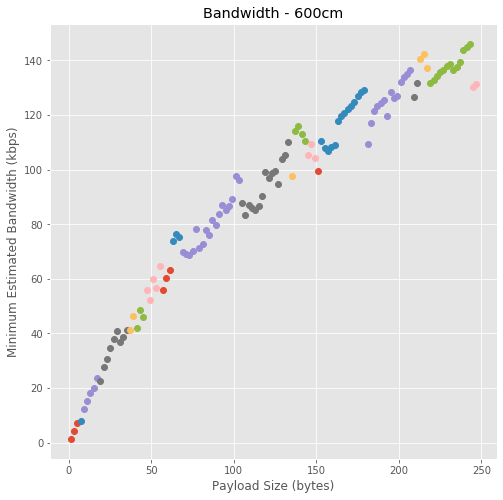

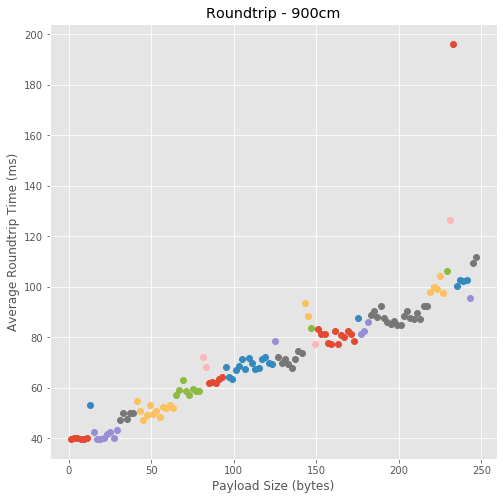

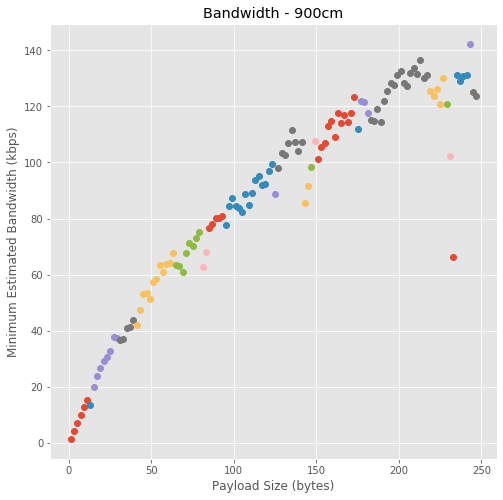

In [25]:

roundtriptest_results = pd.DataFrame()

for test in tests:
    for adapter in adapters:
        for distance in distances:
            for phy in phyTypes:
                if test == "roundtrip":
                    data = roundtrip_tests[(roundtrip_tests[adapter_header] == adapter) & (roundtrip_tests[distance_header] == distance) & (roundtrip_tests[physicalLayer_header] == phy)]
                    
                    roundtripTimes = []
                    payloadSizes = []
                    fig = plt.figure(figsize=[8,8])
                    axis = fig.add_subplot()
                    axis.set_title(r"Roundtrip - {}cm".format(distance))

                    fig1 = plt.figure(figsize=[8,8])
                    axis1 = fig1.add_subplot()
                    axis1.set_title(r"Bandwidth - {}cm".format(distance))
                    for payloadSize in data[payloadSize_header]:
                        #TODO: change this to the correct method
                        roundtripTime = data[data[payloadSize_header] == payloadSize][roundtripTime_header].to_numpy()[0]

                        if (len(roundtripTimes) == 0):
                            roundtripTimes.append(roundtripTime)
                            payloadSizes.append(payloadSize)
                        
                        # 6ms difference, I initially used the 7.5 ms connection interval, but this seems to fit better to the results
                        elif (abs(np.average(roundtripTimes) - roundtripTime) > 0.0055):
                            axis1.plot(payloadSizes, 7*8*np.array(payloadSizes)/(1000*np.array(roundtripTimes)), 'o')
                            axis.plot(payloadSizes, 1000*np.array(roundtripTimes), 'o')
                            roundtriptest_currentresult = {}
                            roundtriptest_currentresult["First Payload Size (bytes)"] = payloadSizes[0]
                            roundtriptest_currentresult["Max Payload Size (bytes)"] = payloadSizes[-1]       
                            roundtriptest_currentresult["Payload Size Diff (bytes)"] = (payloadSizes[-1] - payloadSizes[0]) + 1
                            roundtriptest_currentresult["Average Roundtrip Time (s)"] = np.average(roundtripTimes)
                            roundtriptest_currentresult["Standard Dev Roundtrip Time"] = np.std(roundtripTimes)
                            roundtriptest_currentresult[physicalLayer_header] = phy
                            roundtriptest_currentresult[distance_header] = distance
                            roundtriptest_currentresult[adapter_header] = adapter


                            roundtriptest_results = roundtriptest_results.append(pd.DataFrame([roundtriptest_currentresult]), ignore_index=True)

                            # reset buffers
                            roundtripTimes = [roundtripTime,]
                            payloadSizes = [payloadSize,]
                        else:
                            roundtripTimes.append(roundtripTime)
                            payloadSizes.append(payloadSize)

                    if (len(payloadSizes) > 1):
                        axis1.plot(payloadSizes, 7*8*np.array(payloadSizes)/(1000*np.array(roundtripTimes)), 'o')
                        axis.plot(payloadSizes, 1000*np.array(roundtripTimes), 'o')

                    axis.set_xlabel(r'Payload Size (bytes)')
                    axis.set_ylabel(r'Average Roundtrip Time (ms)')
                    
                    axis1.set_xlabel(r'Payload Size (bytes)')
                    axis1.set_ylabel(r'Minimum Estimated Bandwidth (kbps)')

                if test == "bandwidth":
                    data = bandwidth_tests[bandwidth_tests[adapter_header] == adapter & bandwidth_tests[distance_header] == distance & bandwidth_tests[physicalLayer_header] == phy]
                    #axis.plot(data[payloadSize_header], data[roundtripTime_header], 'o')

#print(roundtriptest_results)

In [26]:

# analyse roundtrip results
#data = roundtriptest_results[roundtriptest_results[distance_header] == 0]
#data.drop(0, inplace=True)
print(roundtriptest_results)

for distance in distances:
    data = roundtriptest_results[roundtriptest_results[distance_header] == distance].reset_index()
    data.drop(0, inplace=True)
    print("Payload Size Diff: {} +- {}".format(np.average(data["Payload Size Diff (bytes)"]), np.std(data["Payload Size Diff (bytes)"])))
    print("Average Roundtrip Time Diff (ms): {} +- {}".format(1000*np.average(data["Average Roundtrip Time (s)"].diff().dropna()), 1000*np.std(data["Average Roundtrip Time (s)"].diff().dropna())))


    First Payload Size (bytes)  Max Payload Size (bytes)  \
0                            1                        29   
1                           31                        67   
2                           69                       103   
3                          105                       141   
4                          143                       177   
..                         ...                       ...   
62                         229                       229   
63                         231                       231   
64                         233                       233   
65                         235                       241   
66                         243                       243   

    Payload Size Diff (bytes)  Average Roundtrip Time (s)  \
0                          29                    0.040435   
1                          37                    0.048220   
2                          35                    0.059336   
3                          37      

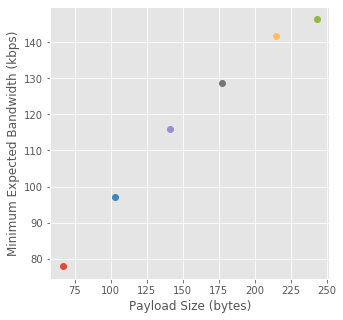

In [27]:

fig = plt.figure(figsize=[5,5])
axis = fig.add_subplot()

data = roundtriptest_results[roundtriptest_results[distance_header] == 0].reset_index()
data.drop(0, inplace=True)

for idx in data.index:
    row = data.loc[idx]
    bandwidth_avg = (row["Max Payload Size (bytes)"] / (1000*row["Average Roundtrip Time (s)"]))*7*8
    axis.set_xlabel(r'Payload Size (bytes)')
    axis.set_ylabel(r'Minimum Expected Bandwidth (kbps)')
    axis.plot(row["Max Payload Size (bytes)"], bandwidth_avg, 'o')